## LESSON——3

In [301]:
import random
from functools import reduce
def topologic(graph):

    sorted_node = []
    
    while graph:
        all_nodes_have_inputs = reduce(lambda a, b: a + b,list(graph.values())) #所有有输入的节点
        all_node_have_outputs = list(graph.keys()) #所有有输出的节点
        all_nodes_only_have_outputs_no_inputs = set(all_node_have_outputs) - set(all_nodes_have_inputs)
    
        if all_nodes_only_have_outputs_no_inputs:
            node = random.choice(list(all_nodes_only_have_outputs_no_inputs))
            
            sorted_node.append(node)
            
            if len(graph) == 1:
                sorted_node += graph[node]
                
            graph.pop(node)
            
            for _,links in graph.items():
                if node in links:links.remove(node)
                    
        else:
            raise TypeError('This graph has circle, which cannot get topological order')
    
    return sorted_node

In [400]:
import random
from functools import reduce
from collections import defaultdict
import numpy as np

def topologic(graph):

    sorted_node = []
    
    while graph:
        all_nodes_have_inputs = reduce(lambda a, b: a + b,list(graph.values())) #所有有输入的节点
        all_node_have_outputs = list(graph.keys()) #所有有输出的节点
        all_nodes_only_have_outputs_no_inputs = set(all_node_have_outputs) - set(all_nodes_have_inputs)
    
        if all_nodes_only_have_outputs_no_inputs:
            node = random.choice(list(all_nodes_only_have_outputs_no_inputs))
            
            sorted_node.append(node)
            
            if len(graph) == 1:
                sorted_node += graph[node]
                
            graph.pop(node)
            
            for _,links in graph.items():
                if node in links:links.remove(node)
                    
        else:
            raise TypeError('This graph has circle, which cannot get topological order')
    
    return sorted_node
  

class Node:
    def __init__(self, inputs= [],name = None, is_trainable = False):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.value = None
        self.gradients = dict()  #存储loss对某个偏导的值
        self.is_trainable = is_trainable
        
        for node in inputs:
            node.outputs.append(self)
    def forward(self):
#         print(f"I am {self.name},i calculate myself value by myself")
        pass
#     def backward(self):
#         for n in self.inputs:
#             print('get ∂{}/∂{}'.format(self.name,n.name))
        
    def __repr__(self):
        return f'Node:{self.name}'



class Placeholder(Node):
    def __init__(self,name = None, is_trainable = False):
        Node.__init__(self,name = name, is_trainable= is_trainable)

    def forward(self):
#         print(f"I am {self.name},my value is {self.value},i calculate myself value, I have been given value")
        pass

    def backward(self):
        self.gradients[self] = self.outputs[0].gradients[self]
    
    def __repr__(self):
        return f'Placeholder:{self.name}'

    
class Linear(Node):
    def __init__(self,x,k,b,name = None):
        Node.__init__(self,inputs = [x,k,b],name = name)

    def forward(self):
#         print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.value = k.value * x.value + b.value
    
    def backward(self):
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.gradients[self.inputs[0]] = self.outputs[0].gradients[self] * k.value
        self.gradients[self.inputs[1]] = self.outputs[0].gradients[self] * x.value
        self.gradients[self.inputs[2]] = self.outputs[0].gradients[self] * 1

#         print('self.gradients[self.inputs[0]] {}'.format(self.gradients[self.inputs[0]]))
#         print('self.gradients[self.inputs[1]] {}'.format(self.gradients[self.inputs[1]]))
#         print('self.gradients[self.inputs[2]] {}'.format(self.gradients[self.inputs[2]]))
    
    def __repr__(self):
        return f'Linear:{self.name}'

class Sigmoid(Node):
    def __init__(self,x,name = None):
        Node.__init__(self,inputs = [x],name = name)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self):
#         print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        x = self.inputs[0]
        self.value = self._sigmoid(x.value)
    
    def backward(self):
        x = self.inputs[0]
        self.gradients[self.inputs[0]] =self.outputs[0].gradients[self] * (self._sigmoid(x.value) * (1 - self._sigmoid(x.value)))
#         print('self.gradients[self.inputs[0]] {}'.format(self.gradients[self.inputs[0]]))
        
        
    def __repr__(self):
        return f'Sigmoid:{self.name}'


    
class Loss(Node):
    """MSE"""
    def __init__(self,y,yhat,name = None):
        Node.__init__(self,inputs = [y,yhat],name = name)
    
    def forward(self):
#         print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        y,yhat = self.inputs[0], self.inputs[1]
        self.value = np.mean((y.value - yhat.value)**2)
    
    def backward(self):
        y,yhat = self.inputs[0], self.inputs[1]
        self.gradients[self.inputs[0]] = 2 * np.mean(y.value - yhat.value)
        self.gradients[self.inputs[1]] = -2 * np.mean(y.value - yhat.value)

#         print('self.gradients[self.inputs[0]] {}'.format(self.gradients[self.inputs[0]]))
#         print('self.gradients[self.inputs[1]] {}'.format(self.gradients[self.inputs[1]]))
        
    def __repr__(self):
        return f'Sigmoid:{self.name}'
    
    
    
def convert_feed_dict_to_graph(feed_dict):
    
    need_expand = [n for n in feed_dict]
    
    computing_graph = defaultdict(list)

    while need_expand:
        n = need_expand.pop(0)

        if n in computing_graph:continue
        
        if isinstance(n,Placeholder): n.value = feed_dict[n]

        for m in n.outputs:
            computing_graph[n].append(m)
            need_expand.append(m)
    return computing_graph

node_x = Placeholder(name = 'x')
node_k = Placeholder(name = 'k',is_trainable = True)
node_b = Placeholder(name = 'b',is_trainable = True)
node_y = Placeholder(name = 'y')
node_linear = Linear(node_x, node_k, node_b,name = 'linear')
node_sigmoid = Sigmoid(x = node_linear,name = 'sigmoid')
node_loss = Loss(y = node_y, yhat = node_sigmoid,name = 'loss')

feed_dict = {
    node_x :3,
    node_y :random.random(),
    node_k :random.random(),
    node_b :0.38
    }

need_feed_value_nodes = [node_x, node_y, node_k, node_b]

sorted_node = topologic(convert_feed_dict_to_graph(feed_dict))

# 模拟神经网络的计算过程
# 就是这个框

In [401]:
feed_dict = {
    node_x :3,
    node_y :random.random(),
    node_k :random.random(),
    node_b :0.38
    }

need_feed_value_nodes = [node_x, node_y, node_k, node_b]

sorted_node = topologic(convert_feed_dict_to_graph(feed_dict))

In [402]:
for node in sorted_node:
    node.forward()

In [403]:
for node in sorted_node[::-1]:
    print('\n I am {}'.format(node.name))
    node.backward()


 I am loss

 I am sigmoid

 I am linear

 I am x

 I am k

 I am y

 I am b


In [418]:
# x,y也更新？？？
learning_rate = 1e-1
for node in sorted_node:
    if node.is_trainable:
        node.value = node.value + -1 * node.gradients[node] * learning_rate
        cmp = 'large' if node.gradients[node] > 0 else 'small'
        print("{}'value is too {}, I need update myself to {}".format(node.name, cmp,node.value))

b'value is too small, I need update myself to 0.3861182465707451
k'value is too small, I need update myself to 0.4286512588727166


### 最后的封装

In [420]:
def forward(graph_sorted_nodes):
    for node in graph_sorted_nodes:
        node.forward()
        #加一段代码
        if isinstance(node,Loss):
            print('Loss value: {}'.format(node.value))
        
def backward(graph_sorted_nodes):
    for node in graph_sorted_nodes[::-1]:
#         print('\n I am {}'.format(node.name))
        node.backward()

def optimize(graph_nodes, learning_rate = 1e-1):
    for node in graph_nodes:
        if node.is_trainable:
            node.value = node.value + -1 * node.gradients[node] * learning_rate
            cmp = 'large' if node.gradients[node] > 0 else 'small'
            print("{}'value is too {}, I need update myself to {}".format(node.name, cmp,node.value))
            
def run_one_epoch(graph_sorted_nodes):
    forward(graph_sorted_nodes)
    backward(graph_sorted_nodes)

## 完整的依次求值 求导 求值的流程是

In [421]:
run_one_epoch(sorted_node)
optimize(sorted_node)

Loss value: 1.3578421759877876e-05
b'value is too small, I need update myself to 0.38741156105437113
k'value is too small, I need update myself to 0.4325312023235947


In [435]:
# 查看梯度下降过程

loss_history = []

for i in range(100):
    run_one_epoch(sorted_node)
    __loss_node = sorted_node[-1]
    assert isinstance(__loss_node,Loss)
    
    loss_history.append(__loss_node.value)
    optimize(sorted_node,learning_rate = 1e-1)

Loss value: 3.2576152278405414e-09
b'value is too small, I need update myself to 0.39008936050376825
k'value is too small, I need update myself to 0.4405646006717858
Loss value: 3.0426083937612127e-09
b'value is too small, I need update myself to 0.39009078963136484
k'value is too small, I need update myself to 0.4405688880545756
Loss value: 2.841796308085599e-09
b'value is too small, I need update myself to 0.3900921707791161
k'value is too small, I need update myself to 0.4405730314978295
Loss value: 2.6542414425047897e-09
b'value is too small, I need update myself to 0.39009350555919736
k'value is too small, I need update myself to 0.44057703583807317
Loss value: 2.479068228271334e-09
b'value is too small, I need update myself to 0.39009479552952336
k'value is too small, I need update myself to 0.4405809057490511
Loss value: 2.3154589576549534e-09
b'value is too small, I need update myself to 0.3900960421955807
k'value is too small, I need update myself to 0.44058464574722306
Loss v

In [436]:
import matplotlib.pyplot as plt

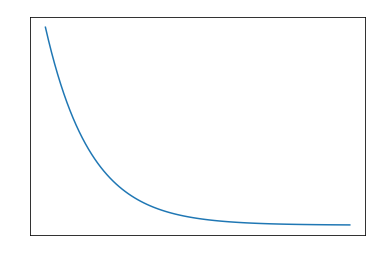

In [437]:
plt.plot(loss_history)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')

In [438]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [444]:
sigmoid(sorted_node[2].value * sorted_node[3].value + sorted_node[0].value)

0.8471207043197627

In [446]:
sorted_node[1].value

0.84712258543166

In [443]:
sorted_node

[Placeholder:b,
 Placeholder:y,
 Placeholder:k,
 Placeholder:x,
 Linear:linear,
 Sigmoid:sigmoid,
 Sigmoid:loss]

# 到这里已经完成了核心内容，可以向前运算，向后运算，梯度更新

# 如何处理多维数据？？
2.19

# 请止步!!!!!

In [129]:
class Node:
    def __init__(self, inputs= [],name = None):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        
        for node in inputs:
            node.outputs.append(self)
            
    def forward(self):
        print(f"I am {self.name} ,i calculate myself value")
    def __repr__(self):
        return f'Node:{self.name}'


In [130]:
# x k b y 是需要输入实际值的数 定义为placeholder

class Placeholder(Node):
    def __init__(self,name = None):
        Node.__init__(self,name = name)

    def forward(self):
        print(f"I am {self.name},my value is {self.value},i calculate myself value, I have been given value")
    
    def __repr__(self):
        return f'Placeholder:{self.name}'
    
node_x = Placeholder(name = 'x')
node_k = Placeholder(name = 'k')
node_b = Placeholder(name = 'b')
node_y = Placeholder(name = 'y')
node_linear = Node(inputs = [node_x, node_k, node_b],name = 'linear')
node_sigmoid = Node(inputs = [node_linear],name = 'sigmoid')
node_loss = Node(inputs = [node_y,node_sigmoid],name = 'loss')

def convert_feed_dict_to_graph(feed_dict):
    
    need_expand = [n for n in feed_dict]
    
    computing_graph = defaultdict(list)

    while need_expand:
        n = need_expand.pop(0)

        if n in computing_graph:continue
            
        if isinstance(n,Placeholder): n.value = feed_dict[n]

        for m in n.outputs:
            computing_graph[n].append(m)
            need_expand.append(m)
    return computing_graph

In [131]:
for node in sorted_node:
    node.forward()

I am y ,i calculate myself value, I have been given value
I am x ,i calculate myself value, I have been given value
I am k ,i calculate myself value, I have been given value
I am b ,i calculate myself value, I have been given value
I am linear ,i calculate myself value by myself
I am sigmoid ,i calculate myself value by myself
I am loss ,i calculate myself value by myself


In [222]:

class Node:
    def __init__(self, inputs= [],name = None):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.value = None
        self.gradients = dict()  #存储loss对某个偏导的值
        
        for node in inputs:
            node.outputs.append(self)
    def forward(self):
        print(f"I am {self.name},i calculate myself value by myself")
    
    def __repr__(self):
        return f'Node:{self.name}'
    
class Linear(Node):
    def __init__(self,x,k,b,name = None):
        Node.__init__(self,inputs = [x,k,b],name = name)

    def forward(self):
        print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.value = k.value * x.value + b.value
        
    def __repr__(self):
        return f'Linear:{self.name}'

In [223]:
class Sigmoid(Node):
    def __init__(self,x,name = None):
        Node.__init__(self,inputs = [x],name = name)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self):
        print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        x = self.inputs[0]
        self.value = self._sigmoid(x.value)
        
    def __repr__(self):
        return f'Sigmoid:{self.name}'

In [224]:
class Loss(Node):
    """MSE"""
    def __init__(self,y,yhat,name = None):
        Node.__init__(self,inputs = [y,yhat],name = name)
    
    def forward(self):
        print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        y,yhat = self.inputs[0], self.inputs[1]
        self.value = np.mean((y.value - yhat.value)**2)
        
    def __repr__(self):
        return f'Sigmoid:{self.name}'

In [140]:
node_x = Placeholder(name = 'x')
node_k = Placeholder(name = 'k')
node_b = Placeholder(name = 'b')
node_y = Placeholder(name = 'y')
node_linear = Linear(node_x, node_k, node_b,name = 'linear')
node_sigmoid = Sigmoid(x = node_linear,name = 'sigmoid')
node_loss = Loss(y = node_y, yhat = node_sigmoid,name = 'loss')

In [141]:
import numpy as np

In [152]:
feed_dict = {
    node_x :3,
    node_y :random.random(),
    node_k :random.random(),
    node_b :0.38
    }

need_feed_value_nodes = [node_x, node_y, node_k, node_b]

sorted_node = topologic(convert_feed_dict_to_graph(feed_dict))
for node in sorted_node:
    node.forward()

I am k,my value is 0.06687895212397421,i calculate myself value, I have been given value
I am b,my value is 0.38,i calculate myself value, I have been given value
I am y,my value is 0.2993957062307556,i calculate myself value, I have been given value
I am x,my value is 3,i calculate myself value, I have been given value
I am linear ,my value is 2.650973615995455,i calculate myself value by my self!
I am sigmoid ,my value is 0.9340709734538888,i calculate myself value by my self!
I am loss ,my value is 0.01786359719043438,i calculate myself value by my self!


# 以上就是向前传播的内容
$\partial$

In [219]:
class Node:
    def __init__(self, inputs= [],name = None):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.value = None
        
        for node in inputs:
            node.outputs.append(self)
    def forward(self):
        print(f"I am {self.name},i calculate myself value by myself")
        
    def backward(self):
        for n in self.inputs:
            print('get ∂{}/∂{}'.format(self.name,n.name))
        
    def __repr__(self):
        return f'Node:{self.name}'



In [229]:
# for node in sorted_node:
#     node.forward()

for node in sorted_node[::-1]:
    print(f'I am {node.name}')
    node.backward()

I am loss
get ∂loss/∂y
get ∂loss/∂sigmoid
I am sigmoid
get ∂sigmoid/∂linear
I am y
I am linear
get ∂linear/∂x
get ∂linear/∂k
get ∂linear/∂b
I am k
I am b
I am x


In [240]:
class Node:
    def __init__(self, inputs= [],name = None):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.value = None
        self.gradients = dict()  #存储loss对某个偏导的值
        
        for node in inputs:
            node.outputs.append(self)
    def forward(self):
        print(f"I am {self.name},i calculate myself value by myself")
        
    def backward(self):
        for n in self.inputs:
            print('get ∂{}/∂{}'.format(self.name,n.name))
        
    def __repr__(self):
        return f'Node:{self.name}'



In [241]:
class Node:
    def __init__(self, inputs= [],name = None):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.value = None
        self.gradients = dict()  #存储loss对某个偏导的值
        
        for node in inputs:
            node.outputs.append(self)
    def forward(self):
        print(f"I am {self.name},i calculate myself value by myself")

    def __repr__(self):
        return f'Node:{self.name}'

class Placeholder(Node):
    def __init__(self,name = None):
        Node.__init__(self,name = name)

    def forward(self):
        print(f"I am {self.name},my value is {self.value},i calculate myself value, I have been given value")
    
    def backward(self):
        print('I got myself gradients: {}'.format(self.outputs[0].gradients[self]))
    
    def __repr__(self):
        return f'Placeholder:{self.name}'

    
class Linear(Node):
    def __init__(self,x,k,b,name = None):
        Node.__init__(self,inputs = [x,k,b],name = name)

    def forward(self):
        print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.value = k.value * x.value + b.value
    
    def backward(self):
        self.gradients[self.inputs[0]] ='*'.join([self.outputs[0].gradients[self],
                                                 '∂{} / ∂{}'.format(self.name, self.inputs[0].name)])
        self.gradients[self.inputs[1]] ='*'.join([self.outputs[0].gradients[self],
                                                 '∂{} / ∂{}'.format(self.name, self.inputs[1].name)])
        self.gradients[self.inputs[2]] ='*'.join([self.outputs[0].gradients[self],
                                                 '∂{} / ∂{}'.format(self.name, self.inputs[2].name)])

        print('self.gradients[self.inputs[0]] {}'.format(self.gradients[self.inputs[0]]))
        print('self.gradients[self.inputs[1]] {}'.format(self.gradients[self.inputs[1]]))
        print('self.gradients[self.inputs[2]] {}'.format(self.gradients[self.inputs[2]]))
    
    def __repr__(self):
        return f'Linear:{self.name}'


    
class Sigmoid(Node):
    def __init__(self,x,name = None):
        Node.__init__(self,inputs = [x],name = name)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self):
        print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        x = self.inputs[0]
        self.value = self._sigmoid(x.value)
    
    def backward(self):
        self.gradients[self.inputs[0]] ='*'.join([self.outputs[0].gradients[self]
                                                  , 'get ∂{}/∂{}'.format(self.name, self.inputs[0].name)])

        print('self.gradients[self.inputs[0]] {}'.format(self.inputs[0]))
        
        
    def __repr__(self):
        return f'Sigmoid:{self.name}'
    
    
class Loss(Node):
    """MSE"""
    def __init__(self,y,yhat,name = None):
        Node.__init__(self,inputs = [y,yhat],name = name)
    
    def forward(self):
        print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        y,yhat = self.inputs[0], self.inputs[1]
        self.value = np.mean((y.value - yhat.value)**2)
    
    def backward(self):
        self.gradients[self.inputs[0]] = 'get ∂{}/∂{}'.format(self.name, self.inputs[0].name)
        self.gradients[self.inputs[1]] = 'get ∂{}/∂{}'.format(self.name, self.inputs[1].name)

        print('self.gradients[self.inputs[0]] {}'.format(self.inputs[0]))
        print('self.gradients[self.inputs[1]] {}'.format(self.inputs[1]))
        
    def __repr__(self):
        return f'Sigmoid:{self.name}'

In [322]:

for node in sorted_node[::-1]:
    print(f'I am {node.name}')
    node.backward()

I am loss
self.gradients[self.inputs[0]] Placeholder:y
self.gradients[self.inputs[1]] Sigmoid:sigmoid
I am sigmoid
self.gradients[self.inputs[0]] Linear:linear
I am linear
self.gradients[self.inputs[0]] get ∂loss/∂sigmoid*get ∂sigmoid/∂linear*∂linear / ∂x
self.gradients[self.inputs[1]] get ∂loss/∂sigmoid*get ∂sigmoid/∂linear*∂linear / ∂k
self.gradients[self.inputs[2]] get ∂loss/∂sigmoid*get ∂sigmoid/∂linear*∂linear / ∂b
I am b
I got myself gradients: get ∂loss/∂sigmoid*get ∂sigmoid/∂linear*∂linear / ∂b
I am k
I got myself gradients: get ∂loss/∂sigmoid*get ∂sigmoid/∂linear*∂linear / ∂k
I am x
I got myself gradients: get ∂loss/∂sigmoid*get ∂sigmoid/∂linear*∂linear / ∂x
I am y
I got myself gradients: get ∂loss/∂y


In [355]:
class Linear(Node):
    def __init__(self,x,k,b,name = None):
        Node.__init__(self,inputs = [x,k,b],name = name)

    def forward(self):
        print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.value = k.value * x.value + b.value
    
    def backward(self):
        x, k, b = self.inputs[0], self.inputs[1], self.inputs[2]
        self.gradients[self.inputs[0]] = self.outputs[0].gradients[self] * k.value
        self.gradients[self.inputs[1]] = self.outputs[0].gradients[self] * x.value
        self.gradients[self.inputs[2]] = self.outputs[0].gradients[self] * 1

        print('self.gradients[self.inputs[0]] {}'.format(self.gradients[self.inputs[0]]))
        print('self.gradients[self.inputs[1]] {}'.format(self.gradients[self.inputs[1]]))
        print('self.gradients[self.inputs[2]] {}'.format(self.gradients[self.inputs[2]]))
    
    def __repr__(self):
        return f'Linear:{self.name}'

class Sigmoid(Node):
    def __init__(self,x,name = None):
        Node.__init__(self,inputs = [x],name = name)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def forward(self):
        print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        x = self.inputs[0]
        self.value = self._sigmoid(x.value)
    
    def backward(self):
        x = self.inputs[0]
        self.gradients[self.inputs[0]] =self.outputs[0].gradients[self] * (self._sigmoid(x.value) * (1 - self._sigmoid(x.value)))
        print('self.gradients[self.inputs[0]] {}'.format(self.gradients[self.inputs[0]]))
        
        
    def __repr__(self):
        return f'Sigmoid:{self.name}'


    
class Loss(Node):
    """MSE"""
    def __init__(self,y,yhat,name = None):
        Node.__init__(self,inputs = [y,yhat],name = name)
    
    def forward(self):
        print(f"I am {self.name} ,my value is {self.value},i calculate myself value by my self!")
        y,yhat = self.inputs[0], self.inputs[1]
        self.value = np.mean((y.value - yhat.value)**2)
    
    def backward(self):
        y,yhat = self.inputs[0], self.inputs[1]
        self.gradients[self.inputs[0]] = 2 * np.mean(y.value - yhat.value)
        self.gradients[self.inputs[1]] = -2 * np.mean(y.value - yhat.value)

        print('self.gradients[self.inputs[0]] {}'.format(self.gradients[self.inputs[0]]))
        print('self.gradients[self.inputs[1]] {}'.format(self.gradients[self.inputs[1]]))
        
    def __repr__(self):
        return f'Sigmoid:{self.name}'
    


In [356]:
for node in sorted_node[::-1]:
    print('\n I am {}'.format(node.name))
    node.backward()


 I am loss
self.gradients[self.inputs[0]] 0.14228049374906804
self.gradients[self.inputs[1]] -0.14228049374906804

 I am sigmoid
self.gradients[self.inputs[0]] -0.014867014773847519

 I am linear
self.gradients[self.inputs[0]] -0.008059390560958682
self.gradients[self.inputs[1]] -0.044601044321542556
self.gradients[self.inputs[2]] -0.014867014773847519

 I am k
I got myself gradients: -0.044601044321542556

 I am x
I got myself gradients: -0.008059390560958682

 I am y
I got myself gradients: 0.14228049374906804

 I am b
I got myself gradients: -0.014867014773847519


## 以上是反向传播

In [ ]:
class Node:
    def __init__(self, inputs= [],name = None, is_trainable = False):
        self.inputs = inputs
        self.outputs = []
        self.name = name
        self.value = None
        self.gradients = dict()  #存储loss对某个偏导的值
        self.is_trainable = is_trainable
        
        for node in inputs:
            node.outputs.append(self)
    def forward(self):
        print(f"I am {self.name},i calculate myself value by myself")
        
node_x = Placeholder(name = 'x')
node_k = Placeholder(name = 'k',is_trainable = True)
node_b = Placeholder(name = 'b',is_trainable = True)
node_y = Placeholder(name = 'y')
node_linear = Linear(node_x, node_k, node_b,name = 'linear')
node_sigmoid = Sigmoid(x = node_linear,name = 'sigmoid')
node_loss = Loss(y = node_y, yhat = node_sigmoid,name = 'loss')

class Placeholder(Node):
    def __init__(self,name = None):
        Node.__init__(self,name = name, is_trainable= is_trainable)

    def forward(self):
        print(f"I am {self.name},my value is {self.value},i calculate myself value, I have been given value")
    
    def backward(self):
        print('I got myself gradients: {}'.format(self.outputs[0].gradients[self]))
    
    def __repr__(self):
        return f'Placeholder:{self.name}'

